# <center> Shearlet inpainting </center>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab

In [3]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


- Inpainting = optimization problem.

Let $x\in\ell^2(\mathbb{Z}^2)$ be a grayscale image partially occluded by a binary mask $\mathbf{M}\in\{0,1\}^{\mathbb{Z}\times\mathbb{Z}}$, i.e.
$$
y =\mathbf{M}x
$$
One can recover $x$ (inpaint) using an sparsifying transformation with the inverse problem
$$
y^*=\min_{x\in \mathbb{R}^{N\times N}} ||S(x)||_1 \text{  s.t. } y=\mathbf{M}x
$$
By iterative thresholding algorithm
$$
x_{n+1} = S^*(T_{\lambda_n}(S(x_n+\alpha_n(y-\mathbf{M}x_n))))
$$

$\lambda_n$ decreases with the iteration number lineraly in $[\lambda_{min},\lambda_{max}]$. 

**Define paramters.**

In [9]:
sigma = 30
scales = 4
thresholdingFactor = 3

**Load data**

In [10]:
# load data
f = img.imread("./data/flowers.png")
f = f[:,:,0].astype(float)

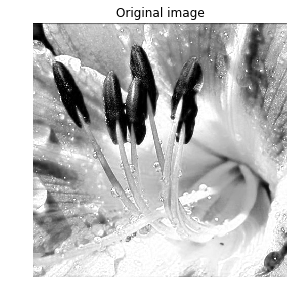

In [11]:
plt.figure(figsize=(10,10))
imageplot(f, 'Original image', [1,2,1])

**Implement iterative hard thresholding**

In [ ]:
function inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem)
    coeffs = Shearlab.sheardec2D(imgMasked,shearletsystem);
    coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
    for i in 1:shearletsystem.nShearlets
        coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end
    delta = maximum(abs.(coeffsNormalized[:]));
    lambda=(stopFactor)^(1/(iterations-1));
    imgInpainted = zeros(size(imgMasked));
    #iterative thresholding
    for it = 1:iterations
        res = mask.*(imgMasked-imgInpainted);
        coeffs = Shearlab.sheardec2D(imgInpainted+res,shearletsystem);
        coeffsNormalized = zeros(size(coeffs))+im*zeros(size(coeffs));
        for i in 1:shearletsystem.nShearlets
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
        end
        coeffs = coeffs.*(abs.(coeffsNormalized).>delta);
        imgInpainted = Shearlab.shearrec2D(coeffs,shearletsystem);  
        delta=delta*lambda;  
    end
    imgInpainted
end

In [ ]:
def inpaint2D(imgMasked,mask,iterations,stopFactor,shearletsystem):
    ## Compute coefficients
    coeffs = pyshearlab.SLsheardec2D(imgMasked, shearletSystem)
    coeffsNormalized = np.zeros(coeffs.shape,complex64)
    for i in range(shearletsystem
            coeffsNormalized[:,:,i] = coeffs[:,:,i]./shearletsystem.RMS[i];
    end

**Create Shearlet System**

In [42]:
shearletSystem = pyshearlab.SLgetShearletSystem2D(0,f.shape[0], f.shape[1], scales)

**Shearlet decomposition**

In [44]:
coeffs = pyshearlab.SLsheardec2D(fnoisy, shearletSystem)

**Thresholding using the RMS (root mean square) as reference**

In [45]:
oldCoeffs = coeffs.copy()
weights = np.ones(coeffs.shape)

In [47]:
for j in range(len(shearletSystem["RMS"])):
    weights[:,:,j] = shearletSystem["RMS"][j]*np.ones((f.shape[0], f.shape[1]))

In [48]:
coeffs = np.real(coeffs)
zero_indices = np.abs(coeffs) / (thresholdingFactor * weights * sigma) < 1
coeffs[zero_indices] = 0

**Reconstruction**

In [52]:
# reconstruction
frec = pyshearlab.SLshearrec2D(coeffs, shearletSystem)

**Compute the PSNR**

In [62]:
PSNR = pyshearlab.SLcomputePSNR(f,frec)
print("{0:.2f}".format(PSNR))

28.16


**Visualize the denoising**

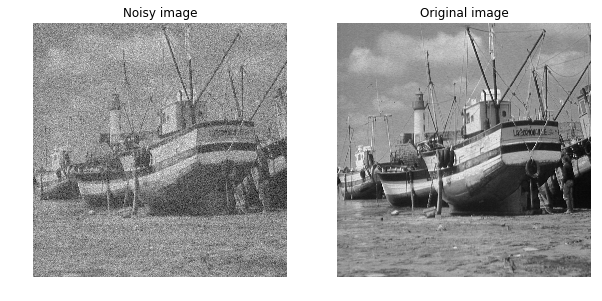

In [57]:
plt.figure(figsize=(10,10))
imageplot(fnoisy, 'Noisy image', [1,2,1])
imageplot(f, 'Original image', [1,2,2])

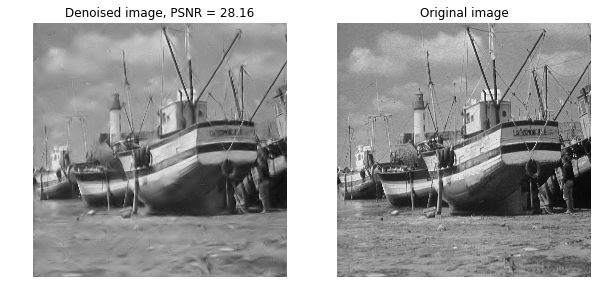

In [61]:
plt.figure(figsize=(10,10))
imageplot(frec, 'Denoised image, PSNR = '+str("{0:.2f}".format(PSNR)), [1,2,1])
imageplot(f, 'Original image', [1,2,2])